In [111]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 100

In [112]:
bbm_pr = pd.ExcelFile('bbm_pr.xlsx')

bbm_pr_2018 = pd.read_excel(bbm_pr, '2018')
bbm_pr_2017 = pd.read_excel(bbm_pr, '2017')
bbm_pr_2016 = pd.read_excel(bbm_pr, '2016')
bbm_pr_2015 = pd.read_excel(bbm_pr, '2015')

In [113]:
bbm_pr_2018

,Rank,Y!Adp9,Value,Name,Team,Pos,g,m/g,p/g,3/g,r/g,a/g,s/g,b/g,fg%,fga/g,ft%,fta/g,to/g
0,1,1.7,1.267030,James Harden,HOU,PG/SG,78,36.752991,36.128205,4.846154,6.615385,7.512821,2.051282,0.730769,0.441592,24.474359,0.878788,11.000000,4.961538
1,2,13.3,0.915986,Paul George,OKC,SG/SF/PF,77,36.901732,28.038961,3.792208,8.142857,4.129870,2.220779,0.441558,0.438042,20.961039,0.840445,7.000000,2.662338
2,3,5.8,0.802711,Karl-Anthony Towns,MIN,C,77,33.048052,24.415584,1.844156,12.389610,3.363636,0.883117,1.623377,0.517871,17.077922,0.835556,5.844156,3.129870
3,4,6.1,0.746828,Kevin Durant,GSW,SF/PF,78,34.635256,25.987179,1.756410,6.346154,5.858974,0.756410,1.076923,0.521330,17.730769,0.885375,6.487179,2.871795
4,5,56.0,0.702161,Nikola Vucevic,ORL,PF/C,80,31.378958,20.812500,1.050000,12.012500,3.837500,1.012500,1.137500,0.517725,16.925000,0.788546,2.837500,1.987500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,184,135.5,-0.444104,Bobby Portis,WAS,PF/C,50,25.964333,14.200000,1.500000,8.020000,1.440000,0.700000,0.420000,0.444268,12.560000,0.793814,1.940000,1.480000
184,185,200.0,-0.456472,Vince Carter,ATL,SG/SF,76,17.504167,7.394737,1.618421,2.552632,1.144737,0.578947,0.355263,0.418803,6.157895,0.712121,0.868421,0.631579
185,186,48.4,-0.462776,Gary Harris,DEN,SG/SF,57,28.758480,12.929825,1.438596,2.771930,2.228070,0.964912,0.333333,0.424528,11.157895,0.798611,2.526316,1.175439
186,187,81.7,-0.463984,Kris Dunn,CHI,PG/SG,46,30.205072,11.282609,0.739130,4.065217,6.021739,1.478261,0.456522,0.424901,11.000000,0.797101,1.500000,2.260870


In [114]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:125% !important; }</style>"))

corr = bbm_pr_2018.corr()
corr.style.background_gradient(cmap='coolwarm')

,Rank,Y!Adp9,Value,g,m/g,p/g,3/g,r/g,a/g,s/g,b/g,fg%,fga/g,ft%,fta/g,to/g
Rank,1,0.652382,-0.92498,-0.288287,-0.615155,-0.616684,-0.207787,-0.47587,-0.423108,-0.410678,-0.343628,-0.2155,-0.542053,-0.138555,-0.541224,-0.47787
Y!Adp9,0.652382,1,-0.669149,0.191192,-0.729264,-0.748996,-0.291386,-0.476231,-0.511689,-0.399838,-0.263706,-0.0368222,-0.726969,-0.12397,-0.657027,-0.679002
Value,-0.92498,-0.669149,1,0.243861,0.607395,0.70728,0.289536,0.492005,0.435737,0.442399,0.358492,0.18776,0.61991,0.172572,0.630066,0.542566
g,-0.288287,0.191192,0.243861,1,-0.0917975,-0.123766,-0.017184,-0.117908,-0.00325432,-0.117359,-0.128608,0.00845838,-0.121598,-0.0617627,-0.114431,-0.0735887
m/g,-0.615155,-0.729264,0.607395,-0.0917975,1,0.76852,0.526195,0.245271,0.543135,0.482157,-0.0294193,-0.264772,0.796072,0.273205,0.591305,0.649606
p/g,-0.616684,-0.748996,0.70728,-0.123766,0.76852,1,0.508955,0.335851,0.531437,0.2974,0.0594642,-0.0393243,0.969776,0.304206,0.856839,0.785763
3/g,-0.207787,-0.291386,0.289536,-0.017184,0.526195,0.508955,1,-0.345646,0.311919,0.223191,-0.408496,-0.6282,0.577063,0.589711,0.183238,0.29793
r/g,-0.47587,-0.476231,0.492005,-0.117908,0.245271,0.335851,-0.345646,1,-0.00846589,0.0678945,0.630475,0.562531,0.220219,-0.368466,0.49323,0.344193
a/g,-0.423108,-0.511689,0.435737,-0.00325432,0.543135,0.531437,0.311919,-0.00846589,1,0.522509,-0.244262,-0.236486,0.560942,0.198461,0.485696,0.779733
s/g,-0.410678,-0.399838,0.442399,-0.117359,0.482157,0.2974,0.223191,0.0678945,0.522509,1,-0.0273747,-0.255512,0.332954,-0.0179267,0.28108,0.397669


### Simple logistic regression model

Looking at the variables, it seems we'll need to deal with categorical variables -- 
- Rank
- Yahoo ADP
- Name
- Team
- Pos (let's remove this, given all the possibilities)

My goal is to see which players end up being higher ranked later in the season. Those are the players we should aim to draft.

Predicting the final rank a player could end up being can be tough, since that will be 188 different classes. It may be wise to sort players into buckets of ranks (top 50, top 100, and so forth).



In [115]:
# we're going to remove Position because there are many variations of position
# deleting name to add anonymity
# deleting value as it is highly correlated to percentile (our predictor variable)

del bbm_pr_2018['Pos']
del bbm_pr_2018['Name']
del bbm_pr_2018['Value']

In [116]:
def sort_ranks(df):
    
    df["percentile"] = np.nan
        
    for i in range(len(df)):
        if df["Rank"][i] <= 40:
            df["percentile"][i] = 1 #top 40
        if df["Rank"][i] > 40 and df["Rank"][i] <= 80:
            df["percentile"][i] = 2 #top 80
        if df["Rank"][i] > 80 and df["Rank"][i] <= 120:
            df["percentile"][i] = 3 #top 120
        elif df["Rank"][i] > 120:
            df["percentile"][i] = 4 #top 200

In [117]:
sort_ranks(bbm_pr_2018)

In [118]:
bbm_pr_2018

,Rank,Y!Adp9,Team,g,m/g,p/g,3/g,r/g,a/g,s/g,b/g,fg%,fga/g,ft%,fta/g,to/g,percentile
0,1,1.7,HOU,78,36.752991,36.128205,4.846154,6.615385,7.512821,2.051282,0.730769,0.441592,24.474359,0.878788,11.000000,4.961538,1.0
1,2,13.3,OKC,77,36.901732,28.038961,3.792208,8.142857,4.129870,2.220779,0.441558,0.438042,20.961039,0.840445,7.000000,2.662338,1.0
2,3,5.8,MIN,77,33.048052,24.415584,1.844156,12.389610,3.363636,0.883117,1.623377,0.517871,17.077922,0.835556,5.844156,3.129870,1.0
3,4,6.1,GSW,78,34.635256,25.987179,1.756410,6.346154,5.858974,0.756410,1.076923,0.521330,17.730769,0.885375,6.487179,2.871795,1.0
4,5,56.0,ORL,80,31.378958,20.812500,1.050000,12.012500,3.837500,1.012500,1.137500,0.517725,16.925000,0.788546,2.837500,1.987500,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,184,135.5,WAS,50,25.964333,14.200000,1.500000,8.020000,1.440000,0.700000,0.420000,0.444268,12.560000,0.793814,1.940000,1.480000,4.0
184,185,200.0,ATL,76,17.504167,7.394737,1.618421,2.552632,1.144737,0.578947,0.355263,0.418803,6.157895,0.712121,0.868421,0.631579,4.0
185,186,48.4,DEN,57,28.758480,12.929825,1.438596,2.771930,2.228070,0.964912,0.333333,0.424528,11.157895,0.798611,2.526316,1.175439,4.0
186,187,81.7,CHI,46,30.205072,11.282609,0.739130,4.065217,6.021739,1.478261,0.456522,0.424901,11.000000,0.797101,1.500000,2.260870,4.0


## One-hot Encoding for Name and Team variables

In [119]:
bbm_pr_2018 = pd.get_dummies(bbm_pr_2018, columns = ['Team'])

In [120]:
del bbm_pr_2018['Rank']

### Modeling - Logistic Regression + train/test split

In [121]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 

In [122]:
X = bbm_pr_2018
y = bbm_pr_2018['percentile']

In [123]:
del X['percentile']

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [125]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.50


In [126]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 5  1  0  1]
 [ 2  3  2  1]
 [ 2  4  0  4]
 [ 1  1  0 11]]


In [127]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.50      0.71      0.59         7
         2.0       0.33      0.38      0.35         8
         3.0       0.00      0.00      0.00        10
         4.0       0.65      0.85      0.73        13

    accuracy                           0.50        38
   macro avg       0.37      0.48      0.42        38
weighted avg       0.38      0.50      0.43        38



### Modeling - Logistic Regression + 10-fold cv

In [128]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

num_instances = len(X)
seed = 10
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = LogisticRegression()
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 40.23% (28.61%)


In [129]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rfmodel = RandomForestClassifier(n_estimators=100, random_state = 42)
# Fit on training data
rfmodel.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [130]:
# Actual class predictions
rf_predictions = rfmodel.predict(X_test)

# Calculate the absolute errors
errors = abs(rf_predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.66 degrees.


In [131]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 64.25 %.


### 50%, 40%, and 64% are quite bad, can we do better with additional data?

In [132]:
bbm_pr = pd.ExcelFile('bbm_pr.xlsx')

bbm_pr_2018 = pd.read_excel(bbm_pr, '2018')
bbm_pr_2017 = pd.read_excel(bbm_pr, '2017')
bbm_pr_2016 = pd.read_excel(bbm_pr, '2016')
bbm_pr_2015 = pd.read_excel(bbm_pr, '2015')

In [133]:
def sort_ranks(df):
    
    df["percentile"] = np.nan
        
    for i in range(len(df)):
        if df["Rank"][i] <= 40:
            df["percentile"][i] = 1 #top 40
        if df["Rank"][i] > 40 and df["Rank"][i] <= 80:
            df["percentile"][i] = 2 #top 80
        if df["Rank"][i] > 80 and df["Rank"][i] <= 120:
            df["percentile"][i] = 3 #top 120
        elif df["Rank"][i] > 120:
            df["percentile"][i] = 4 #top 200

In [134]:
sort_ranks(bbm_pr_2018)
sort_ranks(bbm_pr_2017)
sort_ranks(bbm_pr_2016)
sort_ranks(bbm_pr_2015)

In [135]:
merged_df = bbm_pr_2015.append([bbm_pr_2016, bbm_pr_2017, bbm_pr_2018])

In [136]:
merged_df = pd.get_dummies(merged_df, columns = ['Team'])

In [137]:
merged_df.shape

(752, 49)

In [138]:
del merged_df['Pos']
del merged_df['Rank']
del merged_df['Name']
del merged_df['Value']

In [139]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 

In [140]:
X_moredata = merged_df
y_moredata = merged_df['percentile']
del X_moredata['percentile']

In [141]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_moredata, y_moredata, test_size=0.2, random_state=0)
logreg2 = LogisticRegression()
logreg2.fit(X_train2, y_train2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [142]:
y_pred2 = logreg2.predict(X_test2)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg2.score(X_test2, y_test2)))

Accuracy of logistic regression classifier on test set: 0.67


In [143]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

num_instances = len(X_moredata)
seed = 10
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model2 = LogisticRegression()
results2 = model_selection.cross_val_score(model2, X_moredata, y_moredata, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results2.mean()*100.0, results2.std()*100.0))

Accuracy: 58.79% (23.06%)


### RF Implementation

In [193]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rfmodel_moredata = RandomForestClassifier(n_estimators=100, random_state = 42)
# Fit on training data
rfmodel_moredata.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [194]:
# Actual class predictions
rf_predictions_moredata = rfmodel_moredata.predict(X_test2)

# Calculate the absolute errors
errors_moredata = abs(rf_predictions_moredata - y_test2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_moredata), 2), 'degrees.')

Mean Absolute Error: 0.34 degrees.


In [195]:
# Calculate mean absolute percentage error (MAPE)
mape2 = 100 * (errors_moredata / y_test2)
# Calculate and display accuracy
accuracy_moredata = 100 - np.mean(mape2)
print('Accuracy:', round(accuracy_moredata, 2), '%.')

Accuracy: 82.12 %.


[0.0968975  0.06736404 0.08053188 0.07455594 0.0422582  0.05759461
 0.04232693 0.05659607 0.04040826 0.0448366  0.04931138 0.04233787
 0.05360308 0.03413685 0.00934593 0.00467592 0.00678898 0.00821954
 0.00848358 0.00691586 0.00791637 0.0091126  0.00584435 0.00376658
 0.00450077 0.00561121 0.00582449 0.01027355 0.00466425 0.01224614
 0.0070704  0.00818547 0.00369408 0.01248487 0.00657948 0.00725528
 0.00501088 0.00978256 0.00865181 0.00820736 0.0070947  0.00840392
 0.00433556 0.00629431]


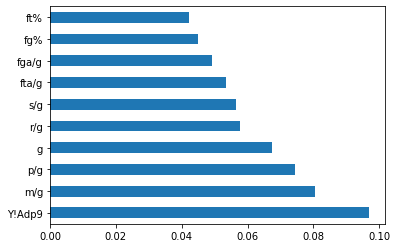

In [200]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model2 = ExtraTreesClassifier()
model2.fit(X_train2,y_train2)
print(model2.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization

feat_importances2 = pd.Series(model2.feature_importances_, index=X_train2.columns)
feat_importances2.nlargest(10).plot(kind='barh')
plt.show()

## Can being on a competitive team result in a higher fantasy finish?
### Top 10 NBA teams (West, East) for the past four years (2015-2018)

In [170]:
top10_2015 = ["GSW", "SAS", "OKC", "LAC", "POR", "DAL", "MEM","HOU","UTA","SAC","DEN",
              "CLE","TOR","MIA","ATL","BOS","CHA","IND","DET","CHI","WAS"]

top10_2016 = ["GSW", "SAS", "HOU", "LAC", "UTA", "OKC", "MEM", "POR", "DEN", "NOR", 
              "BOS", "CLE", "TOR", "WAS", "ATL", "MIL", "IND", "CHI", "MIA", "DET"]

top10_2017 = ["HOU","GSW","POR","OKC", "UTA", "NOR", "SAS", "MIN", "DEN", "LAC", 
              "TOR", "BOS", "PHI", "CLE", "IND", "MIA", "MIL", "WAS", "DET", "CHA"]

top10_2018 = ["GSW", "DEN", "POR", "HOU", "UTA", "OKC", "SAS", "LAC", "SAC", "LAL", 
              "MIL", "TOR", "PHI", "BOS", "IND", "BKN", "OKC", "DET", "CHA", "MIA"]

In [171]:
def competitor(df, playoff_list):
    
    df["tanking"] = np.nan
    
    for i in range(len(df)): 
        if df["Team"][i] in playoff_list:
            df["tanking"][i] = 0
        else:
            df["tanking"][i] = 1

In [172]:
bbm_pr = pd.ExcelFile('bbm_pr.xlsx')

bbm_pr_2018 = pd.read_excel(bbm_pr, '2018')
bbm_pr_2017 = pd.read_excel(bbm_pr, '2017')
bbm_pr_2016 = pd.read_excel(bbm_pr, '2016')
bbm_pr_2015 = pd.read_excel(bbm_pr, '2015')

In [177]:
sort_ranks(bbm_pr_2018)
sort_ranks(bbm_pr_2017)
sort_ranks(bbm_pr_2016)
sort_ranks(bbm_pr_2015)
competitor(bbm_pr_2015, top10_2015)
competitor(bbm_pr_2016, top10_2016)
competitor(bbm_pr_2017, top10_2017)
competitor(bbm_pr_2018, top10_2018)

In [178]:
merged_df2 = bbm_pr_2015.append([bbm_pr_2016, bbm_pr_2017, bbm_pr_2018])

In [179]:
merged_df2 = pd.get_dummies(merged_df2, columns = ['Team'])

In [180]:
merged_df2['percentile']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
183    4.0
184    4.0
185    4.0
186    4.0
187    4.0
Name: percentile, Length: 752, dtype: float64

In [181]:
del merged_df2['Rank']
del merged_df2['Pos']
del merged_df2['Name']
del merged_df2['Value']

In [182]:
merged_df2

,Y!Adp9,g,m/g,p/g,3/g,r/g,a/g,s/g,b/g,fg%,...,Team_OKC,Team_ORL,Team_PHI,Team_PHO,Team_POR,Team_SAC,Team_SAS,Team_TOR,Team_UTA,Team_WAS
0,2.0,79,34.176793,30.063291,5.088608,5.443038,6.670886,2.139241,0.189873,0.503755,...,0,0,0,0,0,0,0,0,0,0
1,4.0,72,35.800000,28.180556,2.583333,8.180556,5.013889,0.958333,1.180556,0.505431,...,1,0,0,0,0,0,0,0,0,0
2,4.0,82,38.105081,28.975610,2.878049,6.109756,7.463415,1.695122,0.621951,0.439085,...,0,0,0,0,0,0,0,0,0,0
3,9.0,72,33.049537,21.152778,1.791667,6.847222,2.583333,1.777778,0.986111,0.505505,...,0,0,0,0,0,0,1,0,0,0
4,7.0,80,34.368542,23.475000,1.262500,7.825000,10.425000,2.037500,0.250000,0.454294,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,135.5,50,25.964333,14.200000,1.500000,8.020000,1.440000,0.700000,0.420000,0.444268,...,0,0,0,0,0,0,0,0,0,1
184,200.0,76,17.504167,7.394737,1.618421,2.552632,1.144737,0.578947,0.355263,0.418803,...,0,0,0,0,0,0,0,0,0,0
185,48.4,57,28.758480,12.929825,1.438596,2.771930,2.228070,0.964912,0.333333,0.424528,...,0,0,0,0,0,0,0,0,0,0
186,81.7,46,30.205072,11.282609,0.739130,4.065217,6.021739,1.478261,0.456522,0.424901,...,0,0,0,0,0,0,0,0,0,0


In [183]:
X3 = merged_df2
y3 = merged_df2['percentile']

In [184]:
del X3['percentile']

In [185]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=0)
logreg3 = LogisticRegression()
logreg3.fit(X_train3, y_train3)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [186]:
y_pred3 = logreg3.predict(X_test3)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg3.score(X_test3, y_test3)))

Accuracy of logistic regression classifier on test set: 0.68


In [187]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

num_instances = len(X3)
seed = 10
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model3 = LogisticRegression()
results3 = model_selection.cross_val_score(model3, X3, y3, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results3.mean()*100.0, results3.std()*100.0))

Accuracy: 58.52% (22.56%)


## RF Implementation

In [188]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rfmodel3 = RandomForestClassifier(n_estimators=100, random_state = 42)
# Fit on training data
rfmodel3.fit(X_train3, y_train3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [189]:
# Actual class predictions
rf_predictions_tank = rfmodel3.predict(X_test3)

# Calculate the absolute errors
errors_tank = abs(rf_predictions_tank - y_test3)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_tank), 2), 'degrees.')



Mean Absolute Error: 0.35 degrees.


In [190]:
# Calculate mean absolute percentage error (MAPE)
mape3 = 100 * (errors_tank / y_test3)
# Calculate and display accuracy
accuracy_tank = 100 - np.mean(mape3)
print('Accuracy:', round(accuracy_tank, 2), '%.')

Accuracy: 82.06 %.


In [191]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train3,y_train3)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization


[0.10320627 0.0652761  0.05939139 0.09318447 0.0438401  0.05943849
 0.04209519 0.04867081 0.04656873 0.04274229 0.04369264 0.04236679
 0.05447279 0.0359122  0.02220125 0.00644891 0.00321905 0.00465537
 0.00728297 0.00710616 0.0069745  0.00420165 0.00801501 0.00802306
 0.00388841 0.00612727 0.00616863 0.00572019 0.00863878 0.00561236
 0.00922972 0.0087329  0.00733191 0.00588379 0.00588659 0.00639479
 0.00616636 0.00687573 0.00735315 0.00826367 0.00461555 0.00802774
 0.00788102 0.00488259 0.00733268]


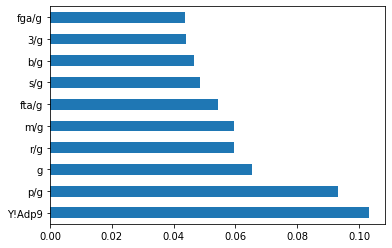

In [192]:
feat_importances = pd.Series(model.feature_importances_, index=X_train3.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

###### Takeaways


It makes sense that those who play more minutes and more games during the season will have more fantasy impact, thus contributing to their final rank.

Really cool to see that 3s and turnovers are NOT a top-10 feature. This alludes to the sudden 3-point era that has embarked upon us, where every player is now shooting 3s. Oftentimes when drafting, turnovers should be neglected since impactful fantasy players often have the ball in their hands (more likely to turn the ball over).

When looking at potential pickups, it's important to note opportunity (minutes per game).